In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import geopandas as gpd
import h3pandas 
sys.path.append('../../../reproducible_figures/scripts/')
import rep_fig_vis as rfv
sys.path.append('../../scripts/')
import create_dataset_utils as cdu
import paired_embeddings_models as pem
sys.path.append('../../../cnn-land-cover/scripts/')
import land_cover_analysis as lca 
import land_cover_visualisation as lcv
import shapely
from tqdm import tqdm, tqdm_notebook
import torch

In [ ]:
df_mapping_locs, _ = cdu.load_names_unique_locs()
df_mapping_locs.head()

,tuple_coords,footprintWKT,count,name_loc
0,"(-2.165105, 50.956811)","POLYGON((-2.17221 50.9523,-2.17221 50.96132,-2...",53410,UKBMS_loc-0000
1,"(-2.646667, 50.775285)","POLYGON((-2.6537 50.77075,-2.6537 50.77982,-2....",51809,UKBMS_loc-0001
2,"(-0.828484, 50.888106)","POLYGON((-0.8357 50.88368,-0.8357 50.89253,-0....",48596,UKBMS_loc-0002
3,"(-1.966038, 50.59722)","POLYGON((-1.97311 50.59273,-1.97311 50.60171,-...",46522,UKBMS_loc-0003
4,"(-0.22994099999999998, 52.409243)","POLYGON((-0.23747 52.40486,-0.23747 52.41363,-...",44130,UKBMS_loc-0004


In [ ]:
df_per_loc = cdu.load_species_dataset()
df_per_loc.head()

,tuple_coords,Melanargia galathea,Pieris napi,Aphantopus hyperantus,Aglais io,Polyommatus icarus,Vanessa atalanta,Lycaena phlaeas,Pararge aegeria,Gonepteryx rhamni,...,Tyria jacobaeae,Euclidia glyphica,Odezia atrata,Melitaea cinxia,Carterocephalus palaemon,Nymphalis polychloros,Nymphalis antiopa,Erebia epiphron,n_visits,name_loc
0,"(-7.824283, 54.259247)",0.0,0.696970,0.242424,0.333333,0.272727,0.060606,0.121212,0.545455,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,33,UKBMS_loc-1044
1,"(-7.457325, 54.15933)",0.0,0.419355,0.387097,0.354839,0.000000,0.064516,0.000000,0.870968,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31,UKBMS_loc-1420
2,"(-6.949025, 54.883646)",0.0,0.363636,0.409091,0.045455,0.000000,0.090909,0.000000,0.818182,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22,UKBMS_loc-0979
3,"(-6.753205, 55.169256)",0.0,0.448276,0.413793,0.034483,0.448276,0.034483,0.034483,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29,UKBMS_loc-0925
4,"(-6.405594, 55.228089)",0.0,0.718750,0.187500,0.375000,0.437500,0.093750,0.500000,0.218750,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,32,UKBMS_loc-0962


In [3]:
ds = pem.DataSetImagePresence(image_folder='/Users/t.vanderplas/data/UKBMS_sent2_ds/sent2-4band/mix-2018-2019/m-06-09/',
                              presence_csv='/Users/t.vanderplas/data/UKBMS_sent2_ds/bms_presence/bms_presence_y-2018-2019_th-200.csv',
                              species_process='top_20',
                              zscore_im=True, 
                              augment_image=False, mode='val')



Found 1329 out of 1455 images in the image folder.
Sorting data by name_loc.
Only keeping top 20 species with most observations.


In [4]:
ds.weights_values

array([2.7020624 , 2.7020624 , 2.7020624 , 2.7020624 , 2.7020624 ,
       2.67555721, 2.60601106, 2.37230982, 2.13612016, 2.11151002,
       1.93717747, 1.90750588, 1.86342024, 1.66866389, 1.38788758,
       1.37239898, 1.18117534, 1.10216876, 1.00703108, 1.        ])

In [ ]:
# import seaborn as sns

# fig, ax = plt.subplots(1, 3, figsize=(10, 3))

# import itertools
# for i, (species1, species2) in enumerate(itertools.combinations(ds.species_list, 2)):
#     sns.jointplot(data=ds.df_presence, x=species1, y=species2, ax=ax[i])
#     ax[i].set_title(f'{species1} vs {species2}')


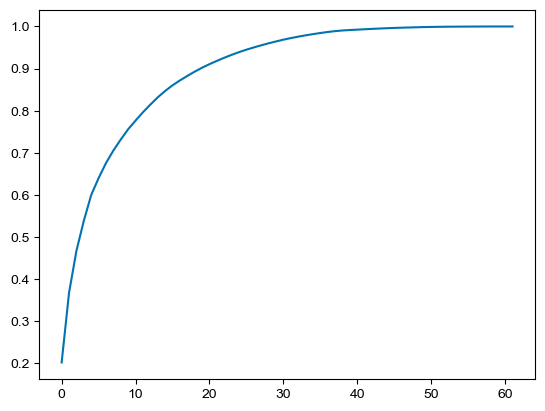

In [ ]:
pres_val = ds.df_presence[ds.species_list].values
from sklearn.decomposition import PCA 
pca = PCA()
pca.fit(pres_val)
plt.plot(np.cumsum(pca.explained_variance_ratio_))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


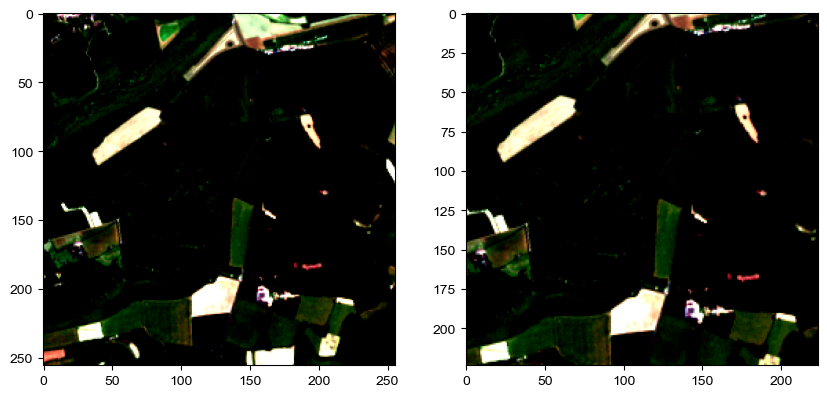

In [5]:
im, pres = ds[0]
im_transformed = ds.transform_data(im)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(im[:3, :, :].permute(1, 2, 0))
ax[1].imshow(im_transformed[:3, :, :].permute(1, 2, 0))

## Results 

- v16 pred / n layers 1 
- v17 pred incl enc / n layers 2 
- v18 pecl / n layers 1 
- v19 post-pecl pred / n layers 1
- v20: pred incl enc / n_layers 2 / freeze True 
- v21: pred / n layers 2 / freeze True 
- v22: pred incl enc / n layers 2 / freeze False 

Findings:
- PECL doesn't work atm (v19 v20). Why does post-pecl pred not work though (V20)? Does passing on models in general work?
- Freezing resnet doesn't matter for pred_incl_enc (v20 v22)
- Pred incl enc works better than pred only (v22 vs v21, v17 vs v16)
- All same plateau .. Check for a trivial solution? (Different random seed.. )

 NON-weighted (B)CE:
- v114: top 20, pretrained False??, BCE, 1 layer
- v116: top 20, seco, BCE, 1 layer
- v117: top 20, seco, BCE, 2 layer
- v118: All species, Seco, BCE, 2 layer mlp pred
- v119: top 20, imagenet, BCE, 2 layer [WORSE than seco]
- v120: top 20, imagenet, BCE, 2 layer, NOT frozen [=> train loss lower but 
val loss higher] 
- v121: pecl
- v122: top 20, seco, CE, 2 layer, [converged solution much further from mean preds than with BCE (0.2 vs 0.03). BCE loss also increases. ]
- v124: top 20, seco, BCE, 2 layer, 32 enc channels [everything above 64 channels.] [Same as 64, just tiny bit slower to converge. ]
- v125: top 20, seco, BCE, 2 layer, 128 channels. [ bit quicker than 64, higher top10 acc]
- v126: top 20, seco, BCE, 2 layer, 256 channels. [again bit quicker than 128]
- v127: top 20, seco, BCE, 2 layer, 512 channels. [slightly quicker than 256/similar]
- v128: top 20, seco, CE, 2 layer, 512 channels 
- v130, top 20, seco, BCE, 2 layer, 512 channels [identical to v127] 
- v131: top 20, seco,  CE, 2 layer, 512 => also identical to CE. 

- v136: top 20, seco, weighted BCE, 2 layer, 512. [faster convergence than non-weighted BCE. ]
- v137: top 20, seco, weighted BCE, 2 layer, 256, lr 1e3
- v138: all sp, seco, weighted BCE, 2 layer, 256, 1e-3 [just ended up predicting the mean.!]
- v139: all sp, seco,  BCE, 2 layer, 246, 1e-3

In [ ]:
final_model, _ = pem.train_pecl(
                    model=None,
                    training_method='pred_incl_enc', 
                    pecl_distance_metric='softmax',
                    species_process='all',
                    use_class_weights=True,
                    n_enc_channels=256, lr=3e-4,
                    n_epochs_max=50, batch_size=64, 
                    pecl_knn=5, pecl_knn_hard_labels=True,
                    freeze_resnet=True, 
                    n_layers_mlp_resnet=1, n_layers_mlp_pred=2,
                    pred_train_loss='bce',
                    pretrained_resnet='seco',
                    # pretrained_resnet=False,
                    # save_model=True,
                    use_lr_scheduler=True,
                    normalise_embedding='l2')

In [1]:
tmp_model = pem.load_model(filename='PECL-ImEn_2024-02-27-1944_vnum-139.data')

post_pecl_model, _ = pem.train_pecl(
                    model=tmp_model,
                    freeze_resnet_fc_loaded_model=True,
                    training_method='pecl', 
                    pecl_distance_metric='softmax',
                    species_process='all', 
                    use_class_weights=True,
                    n_enc_channels=256, lr=1e-5,
                    n_epochs_max=30, batch_size=64, 
                    pecl_knn=2, pecl_knn_hard_labels=True,
                    freeze_resnet=False, 
                    pred_train_loss='weighted-bce',
                    pretrained_resnet='seco',
                    use_lr_scheduler=True)

final_model, _ = pem.train_pecl(
                    model=post_pecl_model,
                    training_method='pred_incl_enc', 
                    pecl_distance_metric='softmax',
                    species_process='all', 
                    use_class_weights=True,
                    n_enc_channels=256, lr=3e-4,
                    n_epochs_max=50, batch_size=64, 
                    pecl_knn=5, pecl_knn_hard_labels=True,
                    freeze_resnet=True, 
                    pred_train_loss='bce',
                    pretrained_resnet='seco',
                    use_lr_scheduler=True)

   

NameError: name 'pem' is not defined

In [98]:
tmp_model.name_train_loss

'pecl-softmax'

In [42]:
tmp_model = pem.load_model(filename='PECL-ImEn_2024-02-27-1944_vnum-139.data')


Loaded ImageEncoder(
  (resnet): ResNet(
    (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

In [146]:
tmp_model = pem.ImageEncoder(n_species=ds.n_species, n_bands=4, freeze_resnet=False,
                             pecl_distance_metric='softmax',
                             training_method='pecl',
                             pretrained_resnet='seco')

No class weights.
Original state dict had 122 keys. Recovered 120 keys from SECO checkpoint.
No unexpected missing keys (only decoder layers are missing).
Loaded Resnet with SeCo weights.


/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/t.vanderplas/anaconda3/envs/satbird/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [149]:
## check for all layers in resnet if they require grad

# tmp_model.resnet 
tmp_model.freeze_resnet_layers(freeze_all_but_last=False, freeze_last=True)
tmp_model.freeze_prediction_model(freeze=False)
for name, param in tmp_model.named_parameters():
    print(name, param.requires_grad)

resnet.conv1.weight True
resnet.bn1.weight True
resnet.bn1.bias True
resnet.layer1.0.conv1.weight True
resnet.layer1.0.bn1.weight True
resnet.layer1.0.bn1.bias True
resnet.layer1.0.conv2.weight True
resnet.layer1.0.bn2.weight True
resnet.layer1.0.bn2.bias True
resnet.layer1.1.conv1.weight True
resnet.layer1.1.bn1.weight True
resnet.layer1.1.bn1.bias True
resnet.layer1.1.conv2.weight True
resnet.layer1.1.bn2.weight True
resnet.layer1.1.bn2.bias True
resnet.layer2.0.conv1.weight True
resnet.layer2.0.bn1.weight True
resnet.layer2.0.bn1.bias True
resnet.layer2.0.conv2.weight True
resnet.layer2.0.bn2.weight True
resnet.layer2.0.bn2.bias True
resnet.layer2.0.downsample.0.weight True
resnet.layer2.0.downsample.1.weight True
resnet.layer2.0.downsample.1.bias True
resnet.layer2.1.conv1.weight True
resnet.layer2.1.bn1.weight True
resnet.layer2.1.bn1.bias True
resnet.layer2.1.conv2.weight True
resnet.layer2.1.bn2.weight True
resnet.layer2.1.bn2.bias True
resnet.layer3.0.conv1.weight True
resnet.l

In [78]:
# train_dl, val_dl = _
val_dl = torch.utils.data.DataLoader(ds, batch_size=32, shuffle=True)


for i_batch, batch in enumerate(val_dl):
    im, label = batch 
    im = im.to(tmp_model.device)
    print(im.shape[0])
    im_enc = tmp_model.forward(im)
    pred = tmp_model.prediction_model(im_enc)
    assert pred.shape == label.shape, f'pred.shape={pred.shape}, label.shape={label.shape}'
    if i_batch == 1:
        break

32
32


Text(0.5, 25.52222222222222, 'embedding dimension')

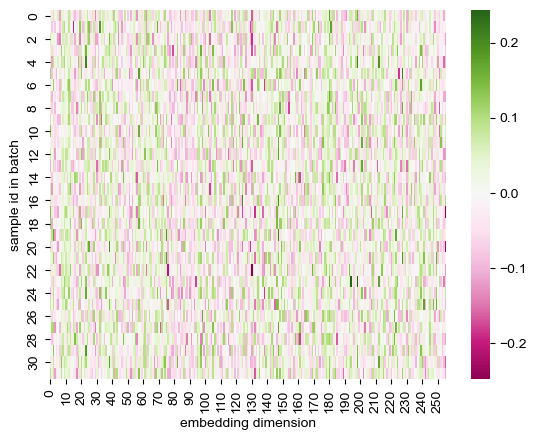

In [73]:
import seaborn as sns
sns.heatmap(im_enc.cpu().detach().numpy(), cmap='PiYG')    
plt.ylabel('sample id in batch')
plt.xlabel('embedding dimension')

(32, 62)
(32, 62) (32,)


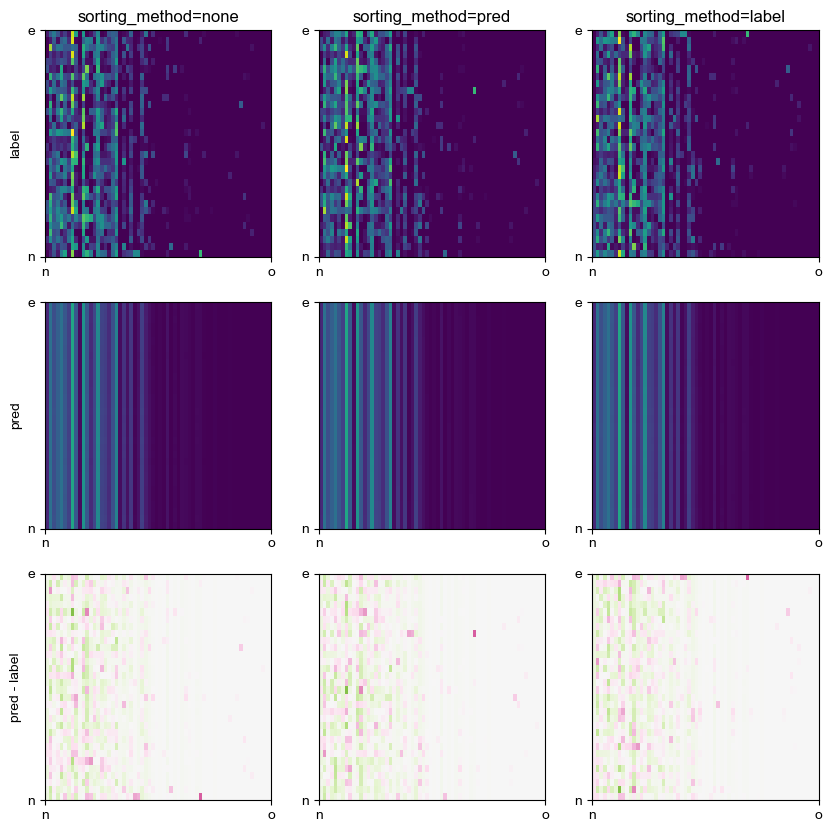

In [79]:
if type(pred) == torch.Tensor:
    if pred.device != 'cpu':
        pred = pred.cpu()
    pred = pred.detach().numpy()
if type(label) == torch.Tensor:
    if label.device != 'cpu':
        label = label.cpu()
    label = label.detach().numpy()
pred_zero_mean = pred - pred.mean(0)
label_zero_mean = label - label.mean(0)

assert pred.max() <= 1, f'pred.max()={pred.max()}'
assert pred.min() >= 0, f'pred.min()={pred.min()}'
assert label.max() <= 1, f'label.max()={label.max()}'
assert label.min() >= 0, f'label.min()={label.min()}'

# accuracy = 

print(label.shape)
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
for col, sorting_method in enumerate(['none', 'pred', 'label']):
    if sorting_method == 'none':
        idx = np.arange(label.shape[0])
    elif sorting_method == 'pred':
        idx = np.argsort(pred.sum(1))
    elif sorting_method == 'label':
        idx = np.argsort(label[:, 0])
        print(label.shape, idx.shape)
    
    ax[0, col].imshow(label[idx, :], vmin=0, vmax=1, cmap='viridis', extent='none', interpolation='none')
    ax[1, col].imshow(pred[idx, :], vmin=-0, vmax=1, cmap='viridis', extent='none', interpolation='none')
    ax[2, col].imshow(pred[idx, :] - label[idx, :], vmin=-1, vmax=1, cmap='PiYG', extent='none', interpolation='none')
    ax[0, col].set_title(f'sorting_method={sorting_method}')
    if col == 0:
        ax[0, col].set_ylabel('label')
        ax[1, col].set_ylabel('pred')
        ax[2, col].set_ylabel('pred - label')

In [80]:
np.mean(np.abs(pred - label)), np.mean(np.abs(label.mean(0)[None, :] - label))



(0.057820775, 0.054450847)

Text(0, 0.5, 'Predicted label')

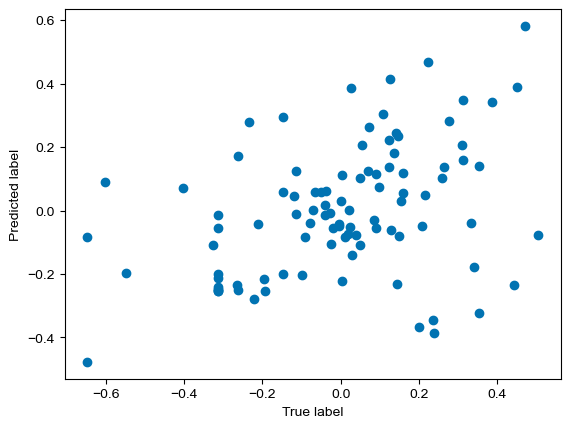

In [ ]:
i_sample = 0
plt.scatter(label_zero_mean[:, :].ravel(), pred_zero_mean[:, :].ravel())
plt.xlabel('True label')
plt.ylabel('Predicted label')

In [ ]:
# tmp_model = dict_models['pred_pca']
# tmp_model = im_enc
# tmp_model = pem.ImageEncoder.load_from_checkpoint("/Users/t.vanderplas/models/PECL/lightning_logs/version_2/checkpoints/best_checkpoint_val-epoch=45-val_loss=0.28-train_loss=0.15.ckpt")
# print(model.learning_rate)
tmp_model.eval()
single_data_sample = ds[0][0]
multi_data_sample = [ds[ii][0] for ii in range(10)]
multi_data_sample = torch.stack(multi_data_sample)
multi_label_sample = torch.stack([ds[ii][1] for ii in range(10)])
pred_enc = tmp_model.forward(multi_data_sample)
pred_pres = tmp_model.prediction_model(pred_enc)

print(pred_enc.shape, pred_pres.shape, multi_label_sample.shape)
tmp_model.top_k_accuracy(preds=pred_pres, target=multi_label_sample, k=20)

torch.Size([10, 32]) torch.Size([10, 20]) torch.Size([10, 20])


tensor(1.)

torch.Size([10, 32])


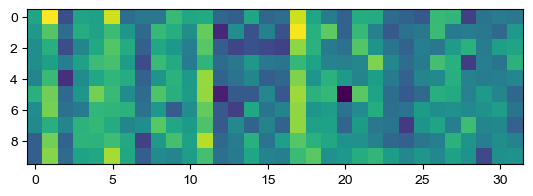

In [ ]:
tmp_pred = tmp_model.resnet(multi_data_sample)
print(tmp_pred.shape)
plt.imshow(tmp_pred.detach().numpy())
# torch.nn.functional.normalize(tmp_pred, p=1, dim=1).abs().sum(1)

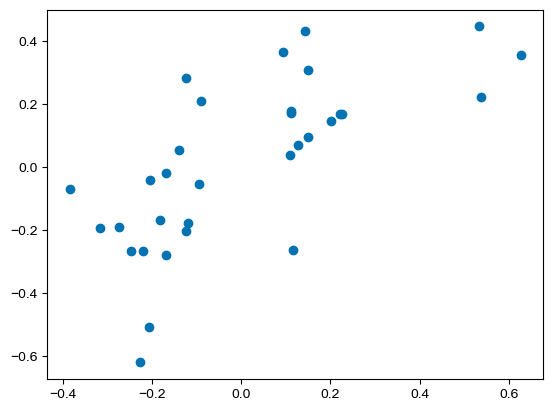

In [ ]:
plt.scatter(tmp_pred[0, :].detach().numpy(), tmp_pred[5, :].detach().numpy())

In [ ]:

target = torch.tensor([[.3, .1, .2, .1],[.1, 1, .3, .5]])
preds = torch.tensor([[0.1, 0.9, 0, 0], [0.2, 0.1, 0.5, 0.2]])
assert preds.shape[0] == target.shape[0], f'preds.shape[0] = {preds.shape[0]} != target.shape[0] = {target.shape[0]}'

loss_fn = torch.nn.BCELoss(reduction='none')
intermediate_loss = loss_fn(preds, target)
weights = torch.tensor([3.1, .2, 1.3, .4])
# print(intermediate_loss)
print(intermediate_loss)
final_loss = (intermediate_loss * weights)
final_loss.mean()

tensor([[ 0.7645,  2.0829, 20.0000, 10.0000],
        [ 0.3618,  2.3026,  0.6931,  0.9163]])


tensor(4.4545)

In [ ]:
n_samples = 6
n_classes = 5
## create two random torch matrices
# matrix 1
matrix1 = np.random.rand(n_samples, n_classes)
# matrix 2
matrix2 = np.random.rand(n_samples, n_classes)
matrix1 = torch.tensor(matrix1).float()
matrix2 = torch.tensor(matrix2).float()
assert matrix1.ndim == 2
tmp = torch.mm(matrix1, matrix1.t())

print(tmp.sum(0), tmp.sum(1))

tensor([5.9671, 7.0691, 7.5548, 8.7021, 6.4149, 2.7796]) tensor([5.9671, 7.0691, 7.5548, 8.7021, 6.4149, 2.7796])


In [ ]:
dist1 = pem.normalised_softmax_distance_batch(matrix1, exclude_diag_in_denominator=False, flatten=True)
dist2 = pem.normalised_softmax_distance_batch(matrix2, exclude_diag_in_denominator=False, flatten=True)

torch.Size([2, 15]) torch.Size([6, 6])
torch.Size([2, 15]) torch.Size([6, 6])


## Look at PECL pass
Look at:
- Distribution of s_ij values
- Distribution of w_ij values
- Steps of PECL pass

In [43]:
ds = pem.DataSetImagePresence(image_folder='/Users/t.vanderplas/data/UKBMS_sent2_ds/sent2-4band/mix-2018-2019/m-06-09/',
                              presence_csv='/Users/t.vanderplas/data/UKBMS_sent2_ds/bms_presence/bms_presence_y-2018-2019_th-200.csv',
                              species_process='all',
                              zscore_im=True, 
                              augment_image=False, mode='val')
from torch.utils.data import DataLoader
train_dl = DataLoader(ds, batch_size=64, shuffle=False)

# tmp_model = pem.ImageEncoder(n_species=ds.n_species, n_bands=4, freeze_resnet=True,
#                              pecl_distance_metric='softmax', n_enc_channels=256,
#                              training_method='pecl',
#                              pretrained_resnet='seco')
tmp_model = pem.load_model(filename='PECL-ImEn_2024-02-27-1944_vnum-139.data')


tmp_model.eval() 


Found 1329 out of 1455 images in the image folder.
Sorting data by name_loc.
Loaded ImageEncoder(
  (resnet): ResNet(
    (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bi

ImageEncoder(
  (resnet): ResNet(
    (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [115]:
with torch.no_grad():
    for i_batch, batch in tqdm(enumerate(train_dl)):
        im, label = batch 
        
        im = im.to(tmp_model.device)
        im_enc = tmp_model.forward(im)
        pred = tmp_model.prediction_model(im_enc)
        
        if i_batch == 0:
            all_labels = label.clone() 
            all_im_encs = im_enc.clone()
            all_preds = pred.clone()
        else:
            all_labels = torch.cat([all_labels, label], dim=0)
            all_im_encs = torch.cat([all_im_encs, im_enc], dim=0)
            all_preds = torch.cat([all_preds, pred], dim=0)
        
        if i_batch == 0:
            break


0it [00:03, ?it/s]


In [116]:
import torch.nn.functional as F
all_labels_norm = F.normalize(all_labels, p=2, dim=1)
all_preds_norm = F.normalize(all_preds, p=2, dim=1)

In [121]:
temperature = 0.5

all_labels_sm = pem.normalised_softmax_distance_batch(all_labels_norm, temperature=temperature, knn=5,
                                                      knn_hard_labels=False, 
                                                      exclude_diag_in_denominator=False, flatten=False)

all_im_encs_sm = pem.normalised_softmax_distance_batch(all_im_encs, temperature=temperature, knn=None,
                                                        exclude_diag_in_denominator=False, flatten=False)
all_im_encs_sm = all_im_encs_sm.cpu().detach().numpy()
all_labels_sm = all_labels_sm.cpu().detach().numpy()

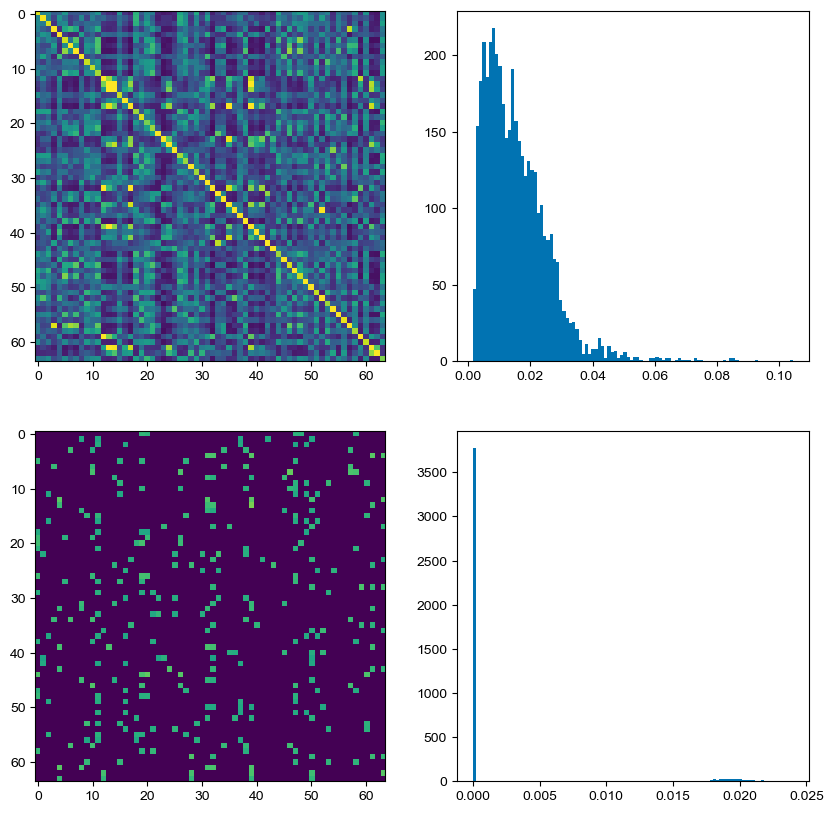

In [122]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(all_im_encs_sm, vmin=0, vmax=0.05, interpolation='none')
ax[0, 1].hist(all_im_encs_sm.ravel(), bins=100)

ax[1, 0].imshow(all_labels_sm, vmin=0, vmax=0.03, interpolation='none')
ax[1, 1].hist(all_labels_sm.ravel(), bins=100);

In [123]:
inds_nz = np.where(all_labels_sm > 0)
all_labels_nz = all_labels_sm[inds_nz]
all_im_encs_nz = all_im_encs_sm[inds_nz]

# all_im_encs_nz.shape, all_labels_nz.shape
(-1 * np.log(all_im_encs_nz + 1e-8) * all_labels_nz).mean()

0.076133385

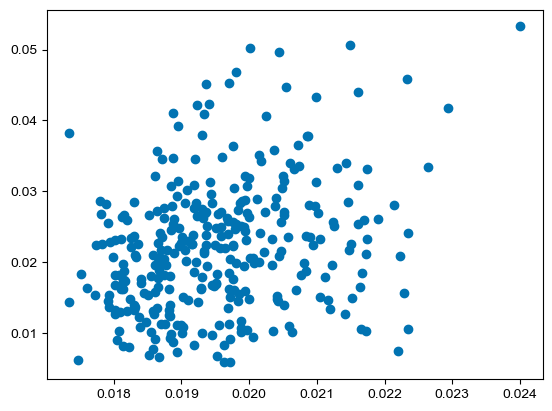

In [125]:
# plt.scatter(all_labels_sm.ravel(), all_im_encs_sm.ravel())
plt.scatter(all_labels_nz, all_im_encs_nz)

In [113]:
# fig, ax = plt.subplots(1, 3, figsize=(12, 4))


# ax[0].hist(all_labels_sm, bins=100)
# ax[0].set_title('all_labels_sm')

# ax[1].hist(all_im_encs_sm, bins=100)
# ax[1].set_title('all_im_encs_sm')

# # ax[2].scatter(all_labels_sm, all_im_encs_sm)
# # ax[2].set_xlabel('all_labels_sm')
# # ax[2].set_ylabel('all_im_encs_sm')

In [8]:
# all_labels_norm_demeaned = all_labels_norm - all_labels_norm.mean(0)
# inner_prod_labels = torch.mm(all_labels_norm_demeaned, all_labels_norm_demeaned.t())
inner_prod_labels = torch.mm(all_labels_norm, all_labels_norm.t())
## set diag to 0
inner_prod_labels = inner_prod_labels - torch.diag(inner_prod_labels.diag())

Got 63 nearest neighbours
[0.983 0.97  0.958 0.943 0.936]


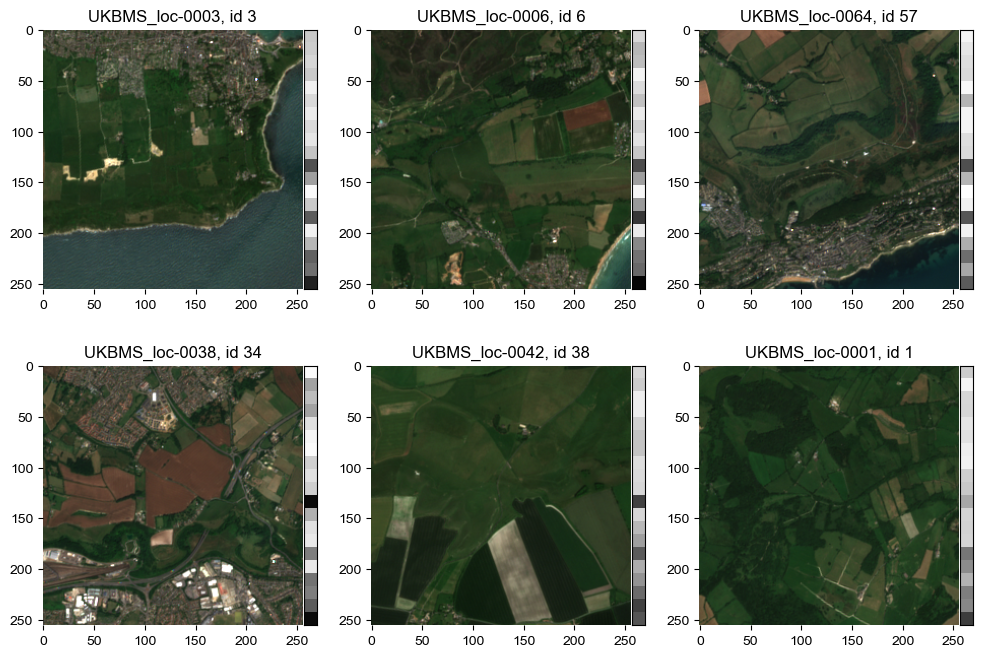

In [9]:

focal_ind = 3

## Using PECL Knn:
# inds_nz = torch.where(all_labels_sm > 0)
# inds_nn = inds_nz[1][inds_nz[0] == focal_ind]
# assert len(inds_nn) == 5, f'len(inds_nn)={len(inds_nn)}'

## Using inner product:
inds_nn = torch.where(inner_prod_labels[focal_ind, :] > 0.15)[0]
print(f'Got {len(inds_nn)} nearest neighbours')
## sort:
inds_nn = inds_nn[torch.argsort(inner_prod_labels[focal_ind, inds_nn], descending=True)]

inds_plot = [focal_ind] + inds_nn.tolist()
inds_plot = inds_plot[:6]
vals_inner = inner_prod_labels[focal_ind, inds_plot[1:]]
## round decimals:
vals_inner = np.round(vals_inner.numpy(), 3)
print(vals_inner)
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
ax = ax.ravel()

for i_ind, ind in enumerate(inds_plot):
    ds.plot_image(ind, ax=ax[i_ind])

(array([262., 408., 452., 390., 365., 370., 330., 321., 303., 263., 221.,
        140.,  99.,  62.,  37.,  23.,  16.,  11.,   8.]),
 array([0.        , 0.00263158, 0.00526316, 0.00789474, 0.01052632,
        0.01315789, 0.01578947, 0.01842105, 0.02105263, 0.02368421,
        0.02631579, 0.02894737, 0.03157895, 0.03421053, 0.03684211,
        0.03947368, 0.04210526, 0.04473684, 0.04736842, 0.05      ]),
 <BarContainer object of 19 artists>)

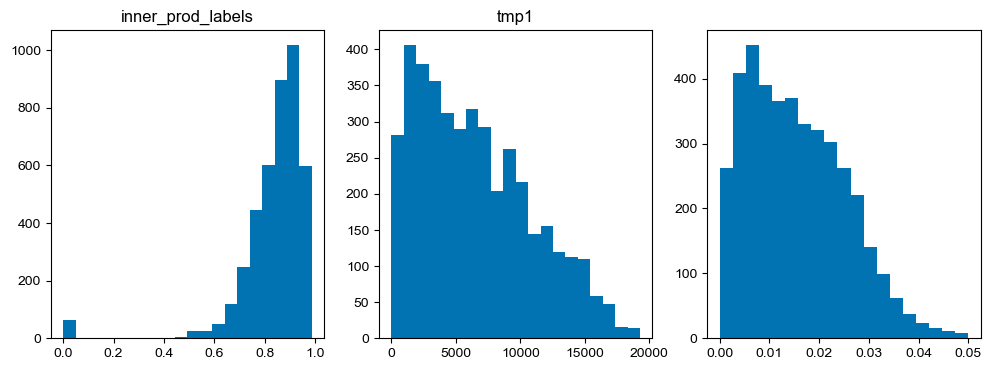

In [10]:
# inner_prod_labels = torch.mm(all_labels_norm, all_labels_norm.t())
tmp1 = inner_prod_labels / 0.1 
tmp1 = torch.exp(tmp1)
tmp2 = torch.sum(tmp1, dim=1) - torch.diag(tmp1)
tmp3 = tmp1 / tmp2[:, None]

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].hist(inner_prod_labels.numpy().ravel(), bins=20)
ax[0].set_title('inner_prod_labels')

ax[1].hist(tmp1.numpy().ravel(), bins=20)
ax[1].set_title('tmp1')

ax[2].hist(tmp3.numpy().ravel(), bins=np.linspace(0, 0.05, 20))


In [213]:
tmp_model.pecl_knn = None

In [270]:
tmp_ims, tmp_preds = tmp_model.pecl_loss(im_enc=all_im_encs[:64, :], pres_vec=all_labels[:64, :])

In [271]:
tmp_inds = torch.where(tmp_preds > 0)

In [287]:
# tmp_ims = tmp_ims[tmp_inds]
(-1 * torch.log(tmp_ims) * tmp_preds[tmp_inds]).mean()

tensor(5.7158)

In [285]:
import torch.nn as nn 
nn.CrossEntropyLoss(reduction='none')(tmp_ims, tmp_preds[tmp_inds])

tensor(1846.0205)